In [1]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import quantstats as qs

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

from tensorflow.keras.utils import plot_model

#sys.path.append('../')
from utils import *

# for Robust location estimation
from statsmodels import robust
import statsmodels.api as sm
from astropy.stats import biweight_location

tf.random.set_seed(25)

# Data preparation

## Load data

In [2]:
prices = pd.read_csv("data/SX5E/close_mat.csv")
composition = pd.read_csv("data/SX5E/SX5E Index_compositionMat.csv")
capitalization = pd.read_csv("data/SX5E/capitalization_mat.csv")

dataframes = {"prices": prices,
              "composition": composition,
              "capitalization": capitalization}

# 4 year training, 1 year testing
train_days = get_trading_dates(start_period="2013-01-01", end_period="2016-12-31", market="EUREX")
test_days = get_trading_dates(start_period="2017-01-01", end_period="2017-12-31", market="EUREX")

# print("Total number of training days:", len(train_days))
# print("First train day:", train_days[0])
# print("Last train day:", train_days[-1])

# print("\nTotal number of test days:", len(test_days))
# print("First test day:", test_days[0])
# print("Last test day:", test_days[-1])

# Set up and select time slice
for k, v in dataframes.items():
    d = setup_tables(v)
    d_train, d_test = d.loc[train_days], d.loc[test_days]
    dataframes[k] = (d_train, d_test)

stocks = get_full_time_stock_in_period(dataframes["composition"][0])
print("\nNumber of stocks fully present in training period:", len(stocks))

for k, v in dataframes.items():
    dataframes[k] = (v[0][stocks], v[1][stocks])

prices_train, prices_test = dataframes["prices"]
composition_train, composition_test = dataframes["composition"]
capitalization_train, capitalization_test = dataframes["capitalization"]

prices = pd.concat(dataframes["prices"])
composition = pd.concat(dataframes["composition"])
capitalization = pd.concat(dataframes["capitalization"])


Number of stocks fully present in training period: 41


## Apply Tukey location estimator on prices

In [3]:
TUKEY_C: float = 9.0
TUKEY_WINDOW: int = 4
tukey = apply_tukey(prices, c=TUKEY_C, window=TUKEY_WINDOW)

In [5]:
display(tukey)

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,153.939608,15.863052,70.854575,44.436658,19.238627,1.380126,72.813778,127.405070,3.231326,13.850115,...,105.634999,7.310501,49.852665,61.648194,7.369072,18.959361,12.610719,29.582595,67.114440,8.771007
2013-01-08,152.295129,15.864724,70.827743,44.922120,19.152028,1.390526,73.053974,126.747672,3.202159,13.846611,...,104.938642,7.356010,49.264694,61.258046,7.436251,18.885706,12.580650,30.070623,66.745362,8.812163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,147.520222,14.513681,104.674164,63.142620,30.576307,2.806773,72.667599,252.430830,5.296620,25.419329,...,188.535460,7.275800,148.367449,96.417197,15.559821,13.994127,9.313864,16.754978,94.511623,15.090592
2017-12-22,146.412571,14.525319,104.062894,63.025675,30.038549,2.812372,72.500877,251.274134,5.289562,25.287773,...,187.624225,7.272463,147.856967,95.296325,15.557825,13.991081,9.234774,16.571814,94.246744,15.033985
2017-12-27,145.584288,14.519068,103.847960,62.925135,29.964425,2.820763,72.326791,250.931691,5.277833,25.200697,...,187.319759,7.274658,147.280248,94.982614,15.542119,14.014684,9.191596,16.392127,94.121017,15.000261
2017-12-28,145.015892,14.502306,103.790028,62.876744,29.942176,2.820962,72.133454,250.297505,5.254052,25.125310,...,187.090081,7.246906,146.709524,94.719488,15.522989,14.018252,9.154871,16.208552,94.056759,15.003275


In [6]:
tukey_test = tukey.loc[test_days]
tukey_train = tukey.loc[train_days][TUKEY_WINDOW-1:]
print("Total number of training days:", len(tukey_train))
print("First train day:", tukey_train.index[0])
print("Last train day:", tukey_train.index[-1])

print("\nTotal number of test days:", len(tukey_test))
print("First test day:", tukey_test.index[0])
print("Last test day:", tukey_test.index[-1])

Total number of training days: 1015
First train day: 2013-01-07 00:00:00
Last train day: 2016-12-30 00:00:00

Total number of test days: 254
First test day: 2017-01-02 00:00:00
Last test day: 2017-12-29 00:00:00


## Plots

In [7]:
plot_stocks = list(stocks)
np.random.shuffle(plot_stocks)
plot_stocks = plot_stocks[:9]

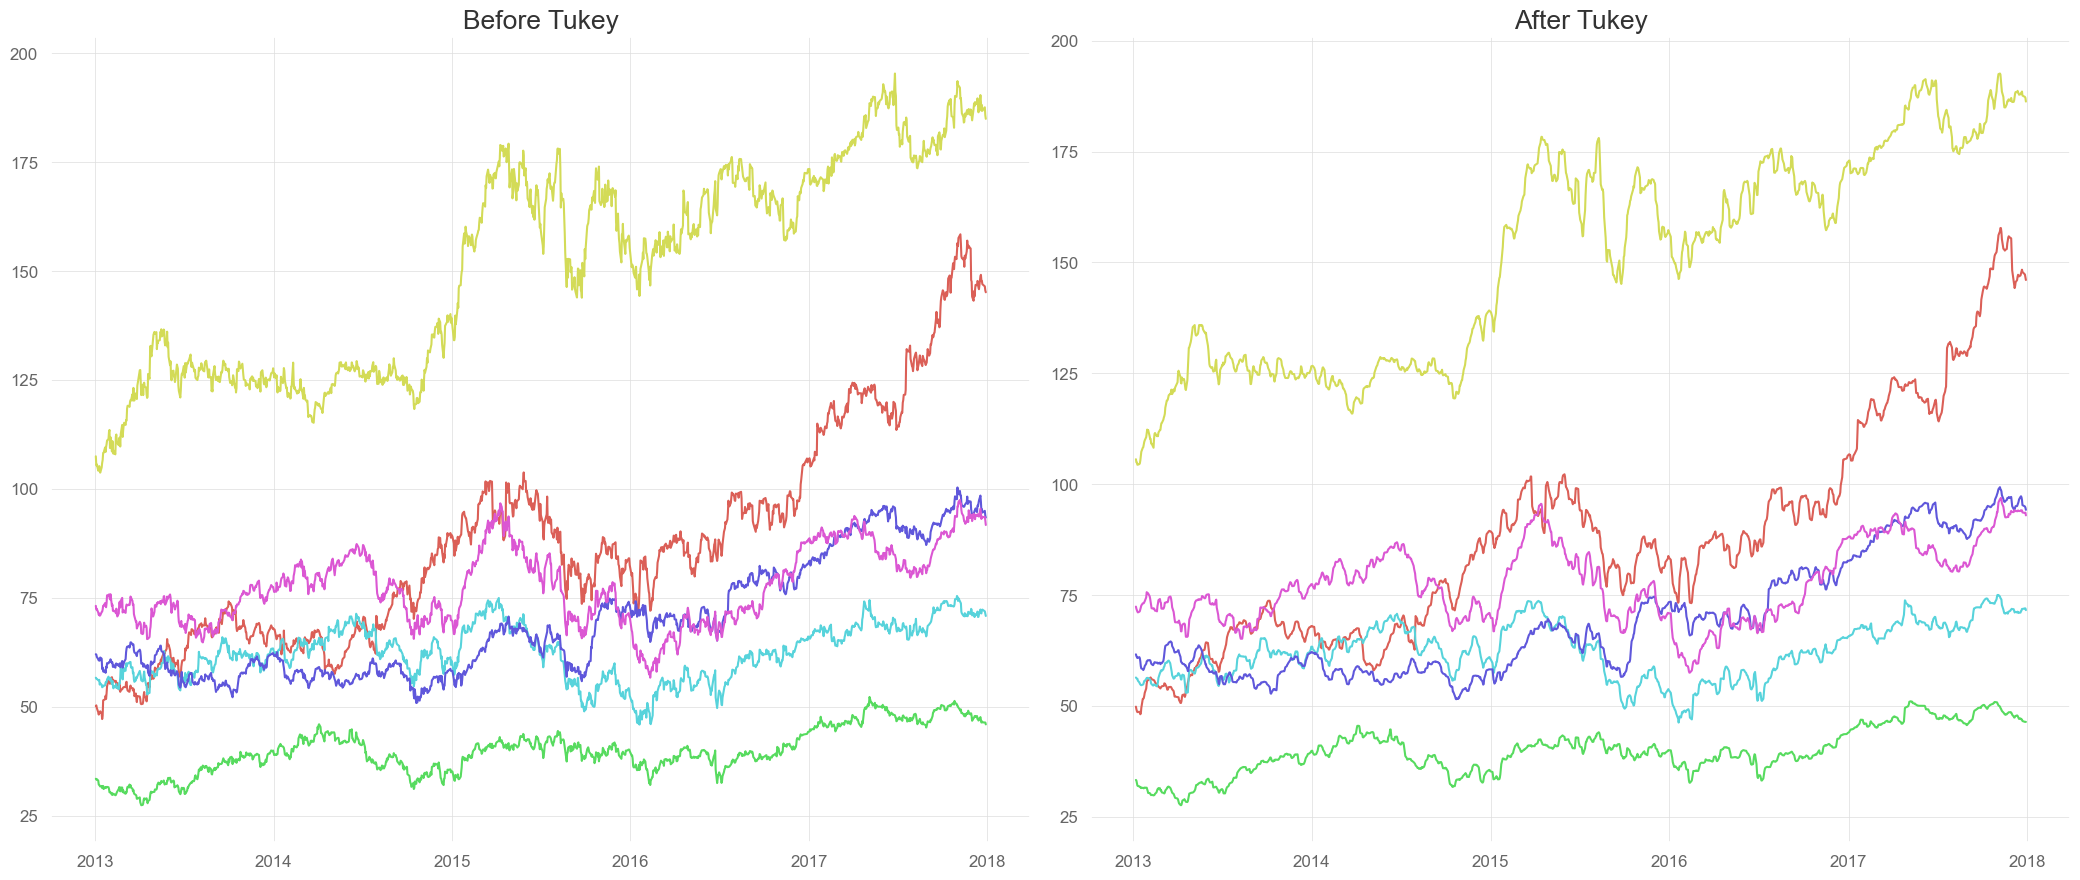

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9), tight_layout=True)

palette = sns.color_palette("hls", 6)

for s, color in zip(plot_stocks, palette):
    ax1.plot(prices[s], color=color, label=s)
    ax2.plot(tukey[s], color=color, label=s)

ax1.set_title("Before Tukey", fontsize="x-large")
ax2.set_title("After Tukey", fontsize="x-large")
plt.plot();

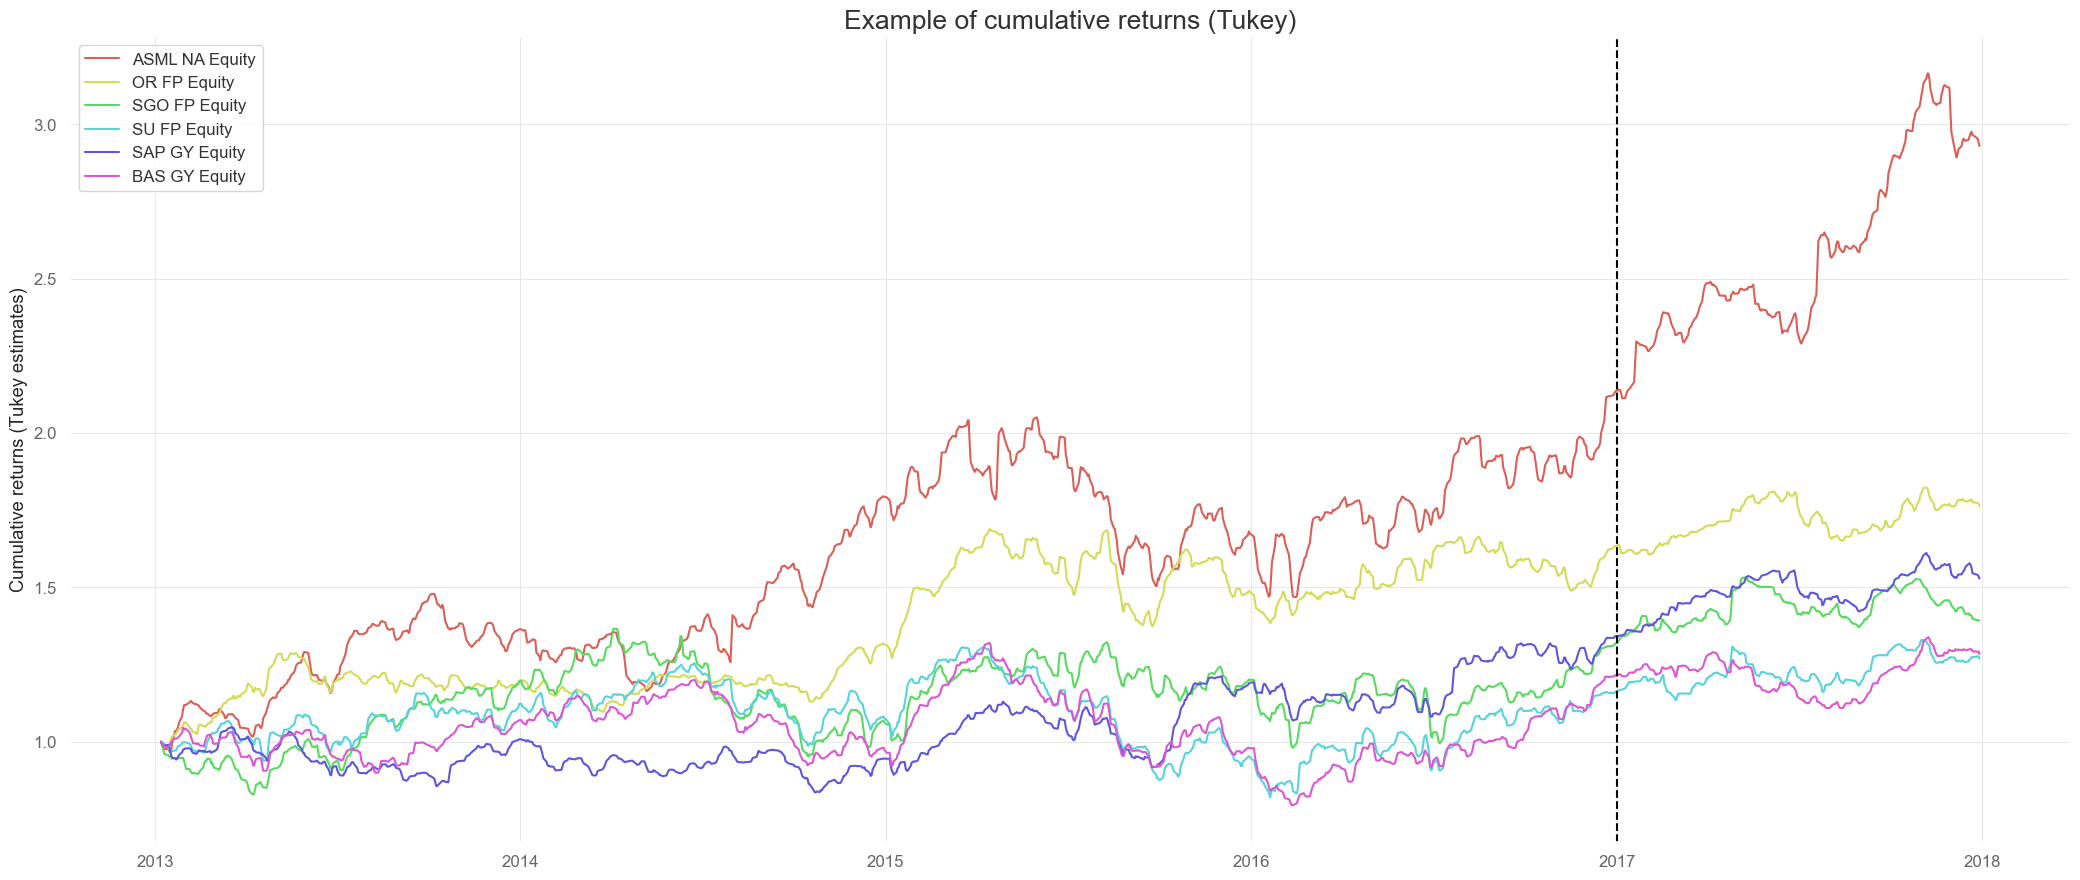

In [9]:
fig, ax = plt.subplots(tight_layout=True, figsize=(21, 9))

cum_ret = price_to_cumulative_returns(tukey[TUKEY_WINDOW-1:])
for s, color in zip(plot_stocks, palette):
    ax.plot(cum_ret[s], color=color, label=s)
ax.legend()
ax.set_ylabel("Cumulative returns (Tukey estimates)")
ax.axvline(x=pd.Timestamp("2017-01-01"), color="black", linestyle="--")
ax.set_title("Example of cumulative returns (Tukey)", fontsize="x-large")
plt.plot();

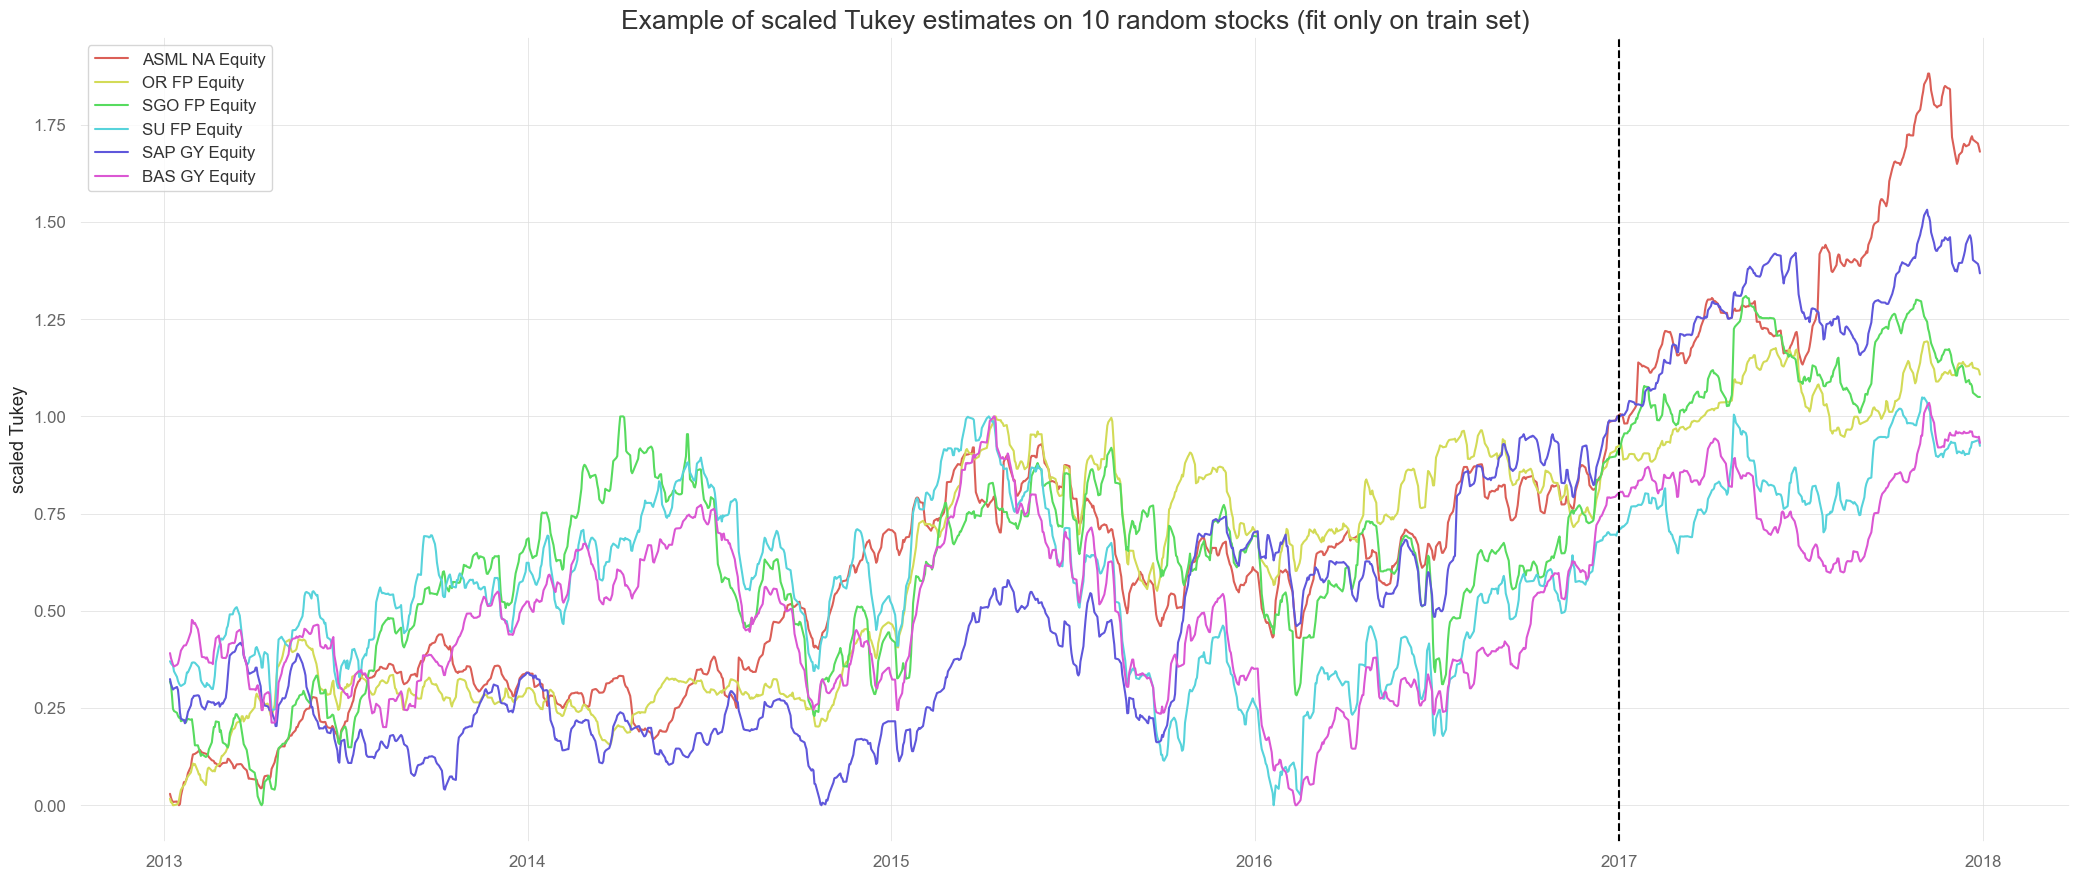

In [10]:
scaler = MinMaxScaler()
scaler.fit(tukey_train)
tukey_scaled = pd.DataFrame(scaler.transform(tukey), index=tukey.index, columns=tukey.columns)

fig, ax = plt.subplots(tight_layout=True, figsize=(21, 9))

for s, color in zip(plot_stocks, palette):
    ax.plot(tukey_scaled[s], color=color, label=s)
ax.legend()
ax.set_ylabel("scaled Tukey")
ax.axvline(x=pd.Timestamp("2017-01-01"), color="black", linestyle="--")
ax.set_title("Example of scaled Tukey estimates on 10 random stocks (fit only on train set)", fontsize="x-large")
plt.plot();

## Prepare data for models
We will use scaled tukeys.

In [11]:
scaler = MinMaxScaler()
scaler.fit(tukey_train)
tukey_train_scaled = pd.DataFrame(scaler.transform(tukey_train), index=tukey_train.index, columns=tukey_train.columns)

In [12]:
LOOK_BACK = 250
FORECAST_HORIZON = 1
N_STOCKS = len(stocks)

X_train, y_train = split_sequence(tukey_train_scaled, look_back=LOOK_BACK, forecast_horizon=FORECAST_HORIZON)
print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)

X_train.shape = (765, 250, 41)
y_train.shape = (765, 1, 41)


# Train model

## Define model

In [13]:
model1 = Sequential(name='CNN-LSTM')

model1.add(Conv1D(filters=N_STOCKS, kernel_size=3, activation='relu', input_shape=(LOOK_BACK, N_STOCKS)))
model1.add(MaxPooling1D(pool_size=2))

model1.add(Conv1D(filters=N_STOCKS, kernel_size=5, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

model1.add(Conv1D(filters=N_STOCKS, kernel_size=7, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

model1.add(Conv1D(filters=N_STOCKS, kernel_size=9, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

model1.add(Flatten())

model1.add(RepeatVector(FORECAST_HORIZON))

model1.add(LSTM(200, activation='relu', return_sequences=True))

model1.add(TimeDistributed(Dense(100, activation='relu')))

model1.add(TimeDistributed(Dense(N_STOCKS)))

model1.compile(loss='mse', optimizer='adam')

In [14]:
print(model1.summary())

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 248, 41)           5084      
                                                                 
 max_pooling1d (MaxPooling1  (None, 124, 41)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 41)           8446      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 60, 41)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 54, 41)            11808     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 27, 41)            0  

## Train model

In [15]:
n_epochs = 20
history = model1.fit(X_train, y_train, epochs=n_epochs, batch_size=32)

Epoch 1/20

24/24 [==============================] - 9s 42ms/step - loss: 0.1503
Epoch 2/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0386
Epoch 3/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0230
Epoch 4/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0153
Epoch 5/20
24/24 [==============================] - 1s 28ms/step - loss: 0.0127
Epoch 6/20
24/24 [==============================] - 1s 29ms/step - loss: 0.0123
Epoch 7/20
24/24 [==============================] - 1s 28ms/step - loss: 0.0093
Epoch 8/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0080
Epoch 9/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0076
Epoch 10/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0071
Epoch 11/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0063
Epoch 12/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0051
Epoch 13/20
24/24 [=================

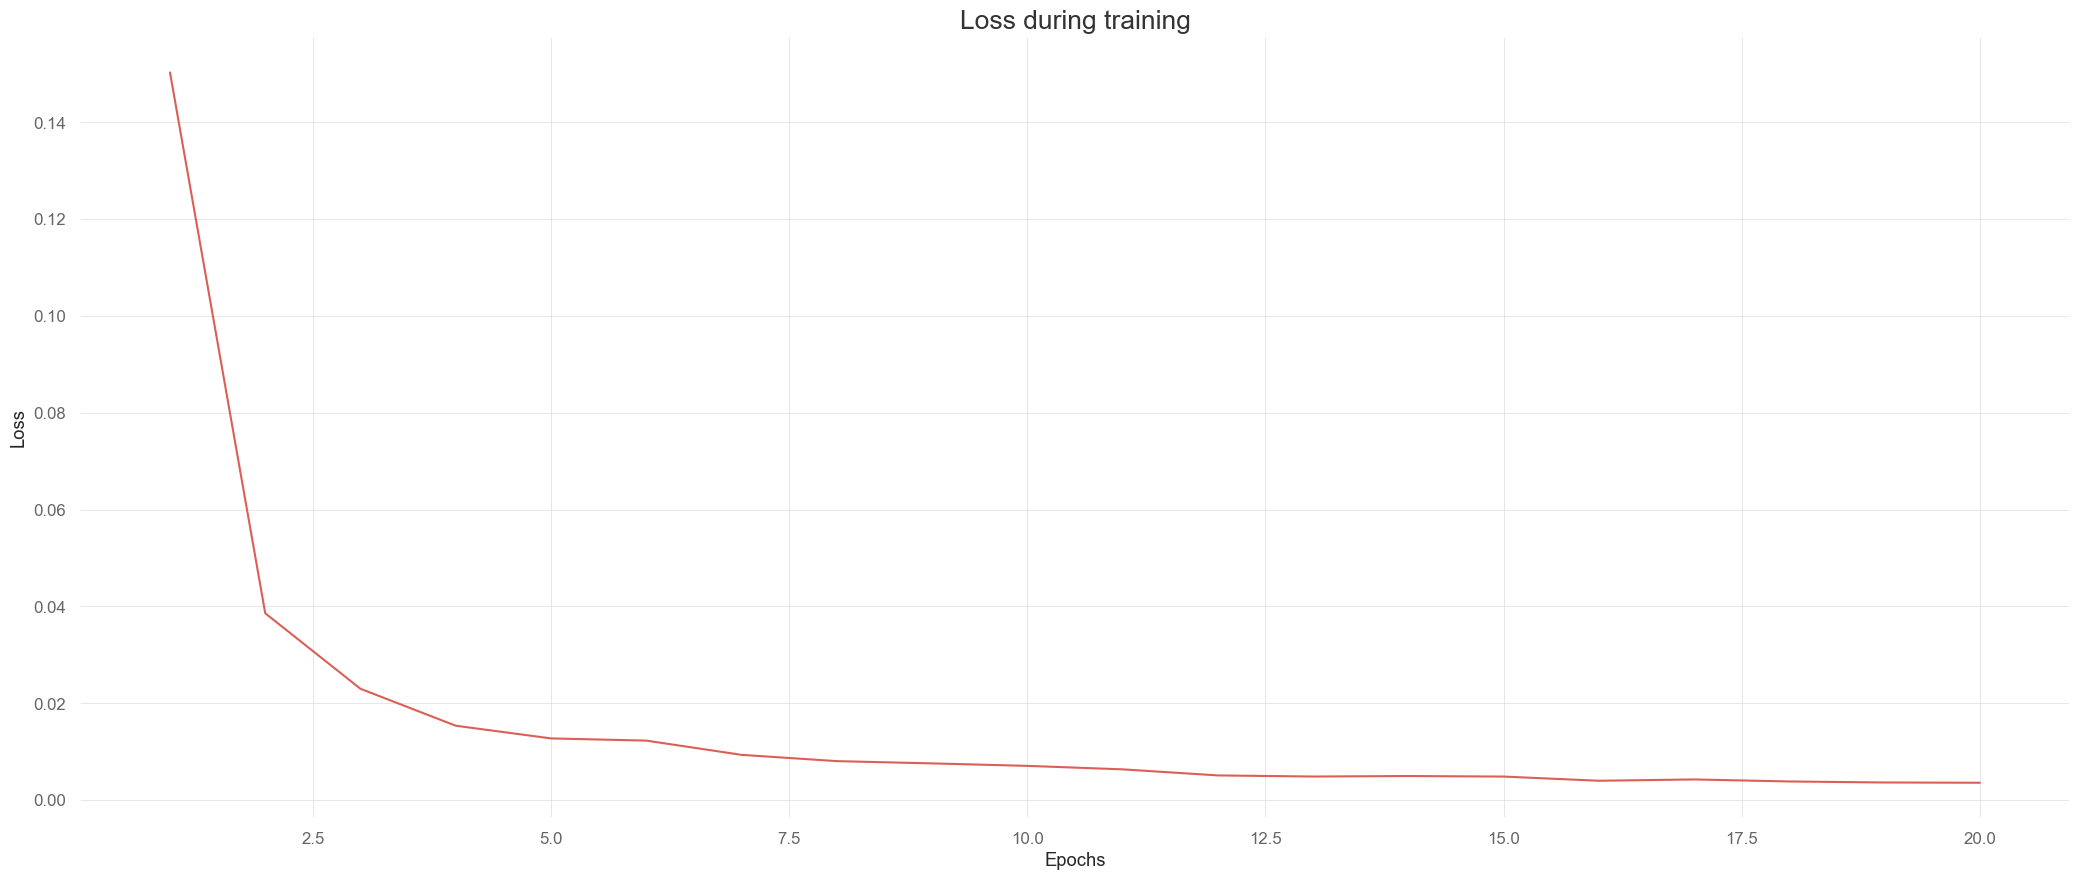

In [16]:
fig, ax = plt.subplots(tight_layout=True, figsize=(21, 9))

ax.plot(np.arange(1, n_epochs+1), history.history["loss"], color=palette[0], label="loss")
ax.set_xlabel("Epochs")
ax.set_title("Loss during training", fontsize="x-large")
ax.set_ylabel("Loss")
plt.show()

## Create benchmark

### Equal weight on all the stocks

In [17]:
ew_benchmark = pd.concat([prices_train[-1:], prices_test])
ew_benchmark = price_to_cumulative_returns(ew_benchmark)
ew_benchmark = ew_benchmark / len(ew_benchmark.columns)
ew_benchmark = ew_benchmark.sum(axis=1)
ew_benchmark.rename("Equal weight benchmark strategy", inplace=True);

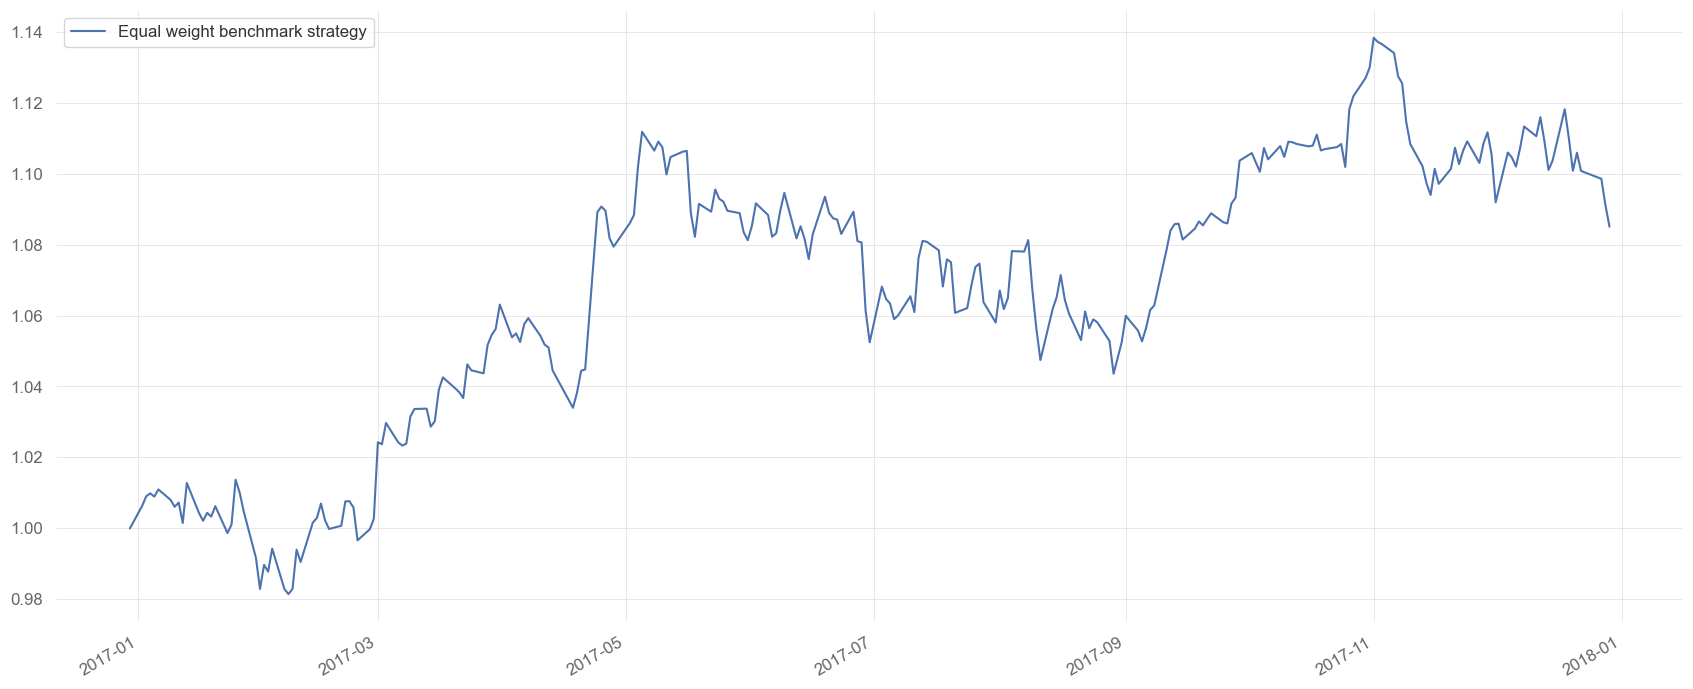

In [18]:
df_benchmark = pd.DataFrame((ew_benchmark)).plot(figsize=(21, 9))

# Forecast

## Compute forecast

In [19]:
start = y_train[-LOOK_BACK:]
forecast_predictions = forecast(model1, start, LOOK_BACK, N_STOCKS, forecast_steps=len(prices_test))
print("Predictions shape:", forecast_predictions.shape)
forecast_predictions = forecast_predictions.reshape(forecast_predictions.shape[0], N_STOCKS)
print("Predictions shape:", forecast_predictions.shape)

Predictions shape: (254, 1, 41)
Predictions shape: (254, 41)


In [20]:
# Inverse transform
tukey_forecast = scaler.inverse_transform(forecast_predictions)
tukey_forecast = pd.DataFrame(tukey_forecast, index=tukey_test.index, columns=tukey_train.columns)

## Real top stocks

In [21]:
util_df_prices = pd.concat([prices_train[-1:], prices_test])
real_top_portfolios = get_ranking(util_df_prices, N=[5, 7, 10], prices=True, log=False)
real_top_ten = real_top_portfolios["Top 10"]
print(real_top_ten)

['ASML NA Equity', 'MC FP Equity', 'EOAN GY Equity', 'DG FP Equity', 'VOW3 GY Equity', 'VIV FP Equity', 'ENEL IM Equity', 'ALV GY Equity', 'null.2', 'ENGI FP Equity']


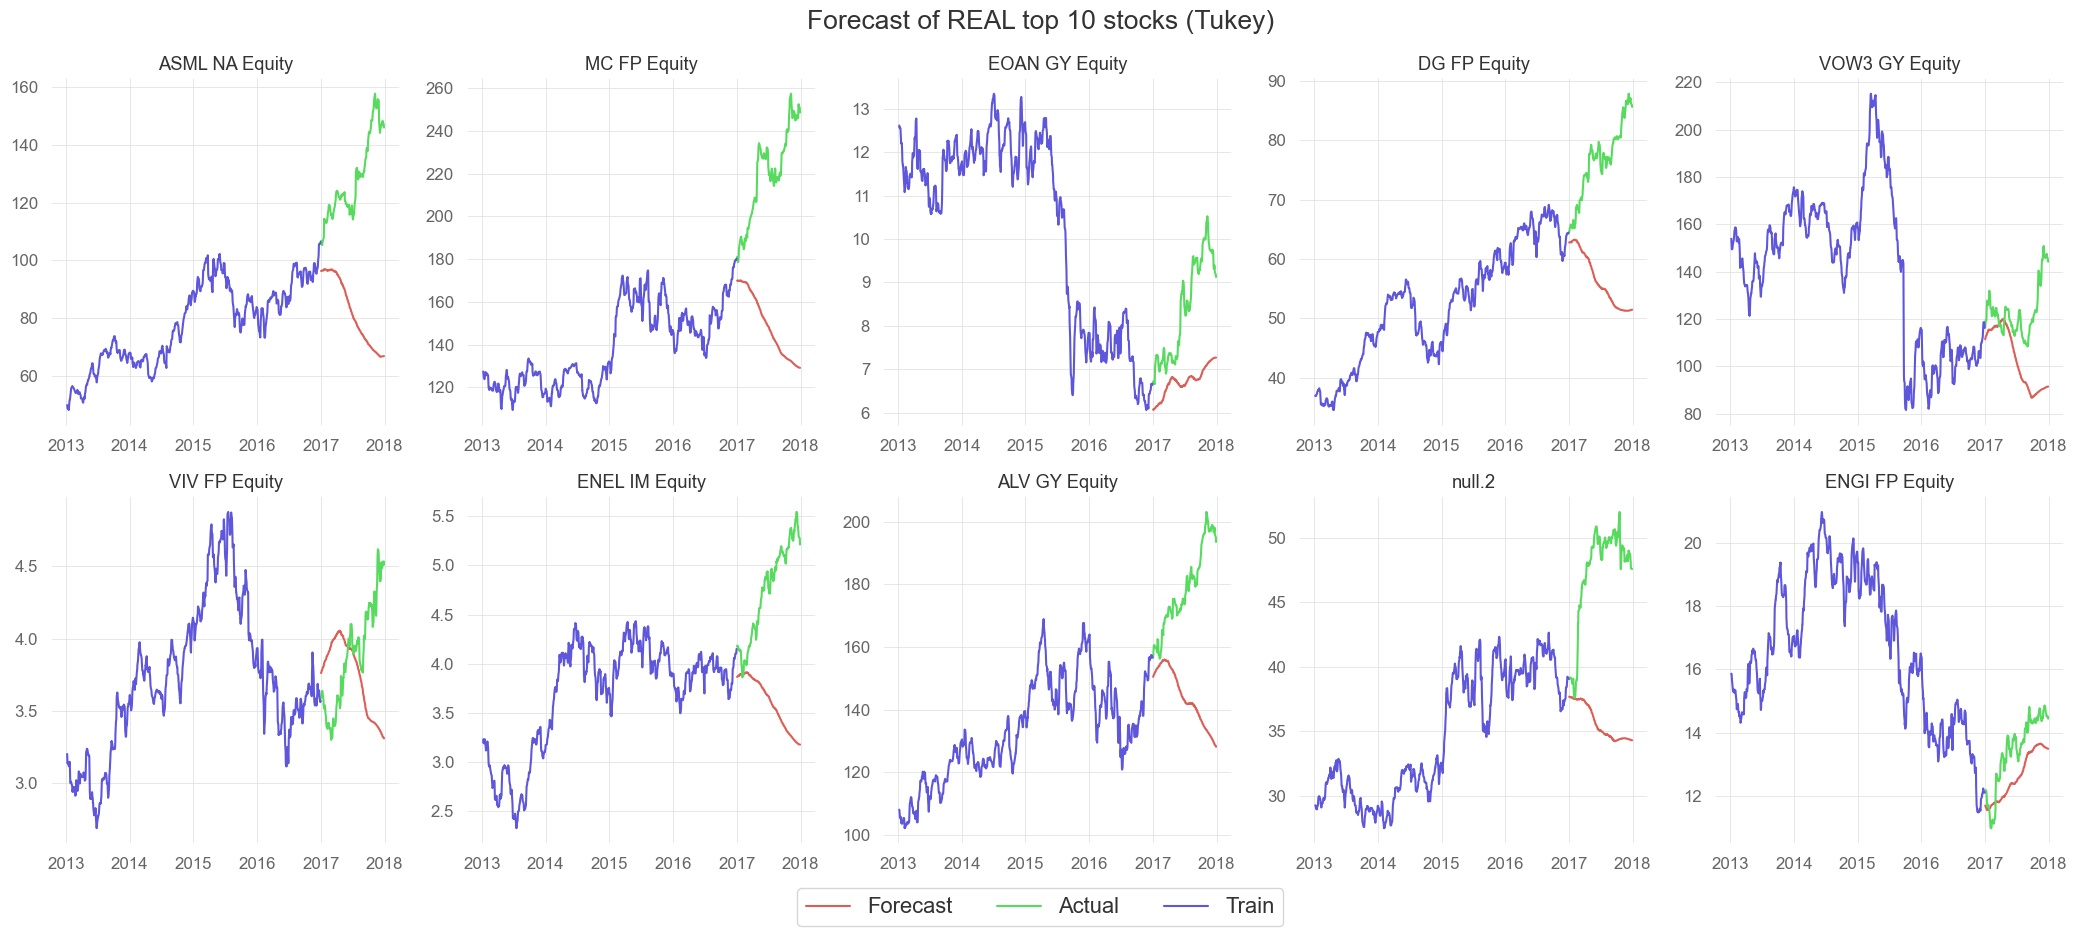

In [22]:
palette = sns.color_palette("hls", 3)

n_rows = 2
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 9), tight_layout=True)
for i in range(n_cols*n_rows):
    ax = axes[i // n_cols, i % n_cols]
    s = real_top_ten[i]
    ax.plot(tukey_forecast[s], label="Forecast", color=palette[0])
    ax.plot(tukey_test[s], label="Actual", color=palette[1])
    ax.plot(tukey_train[s], label="Train", color=palette[2])
    ax.set_title(s)
    
# bottom legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize="large")
plt.suptitle("Forecast of REAL top 10 stocks (Tukey)", fontsize="x-large")
plt.show();

In [22]:
# Compute real top portfolios returns
test_returns = price_to_returns(util_df_prices, log=False, drop_na=False)[1:]
perf_dict, ret_dict = calc_portfolios(assets=real_top_portfolios, test_ret=test_returns, log=False)
df_perf_real = pd.DataFrame(perf_dict, index=["Real"]).T

## Selected top stocks 

In [23]:
util_df_forecast = pd.concat([tukey_train[-1:], tukey_forecast])
selected_top_portfolios = get_ranking(util_df_forecast, N=[5, 7, 10], prices=True, log=False)
selected_top_ten = selected_top_portfolios["Top 10"]
print(selected_top_ten)

['ENGI FP Equity', 'EOAN GY Equity', 'BN FP Equity', 'ABI BB Equity', 'EL FP Equity', 'null.2', 'TEF SQ Equity', 'SAN FP Equity', 'DG FP Equity', 'ORA FP Equity']


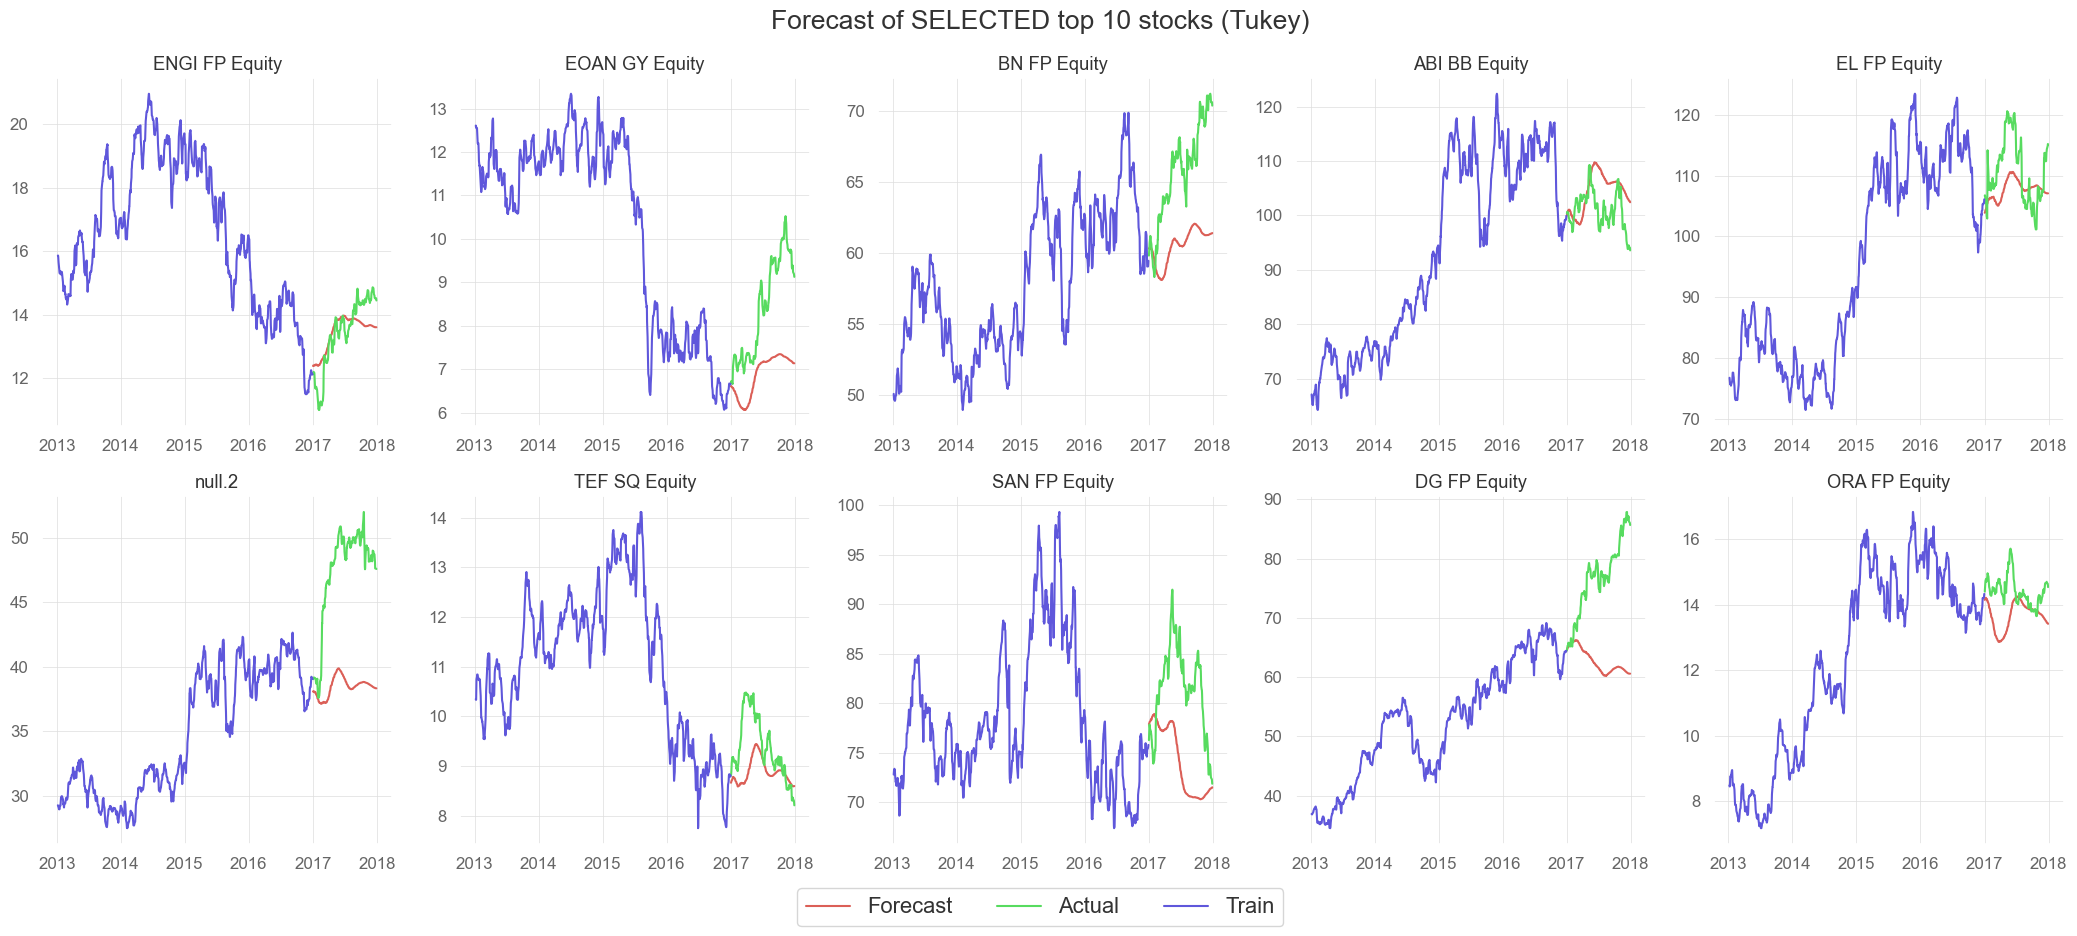

In [24]:
palette = sns.color_palette("hls", 3)

n_rows = 2
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 9), tight_layout=True)
for i in range(n_cols*n_rows):
    ax = axes[i // n_cols, i % n_cols]
    s = selected_top_ten[i]
    ax.plot(tukey_forecast[s], label="Forecast", color=palette[0])
    ax.plot(tukey_test[s], label="Actual", color=palette[1])
    ax.plot(tukey_train[s], label="Train", color=palette[2])
    ax.set_title(s)
    
# bottom legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize="large")
plt.suptitle("Forecast of SELECTED top 10 stocks (Tukey)", fontsize="x-large")
plt.show();

In [25]:
test_returns = price_to_returns(util_df_prices, log=False, drop_na=False)[1:]
perf_dict_forecast, ret_dict_forecast = calc_portfolios(assets=selected_top_portfolios, test_ret=test_returns, log=False)
df_perf_selected = pd.DataFrame(perf_dict_forecast, index=["Selected"]).T

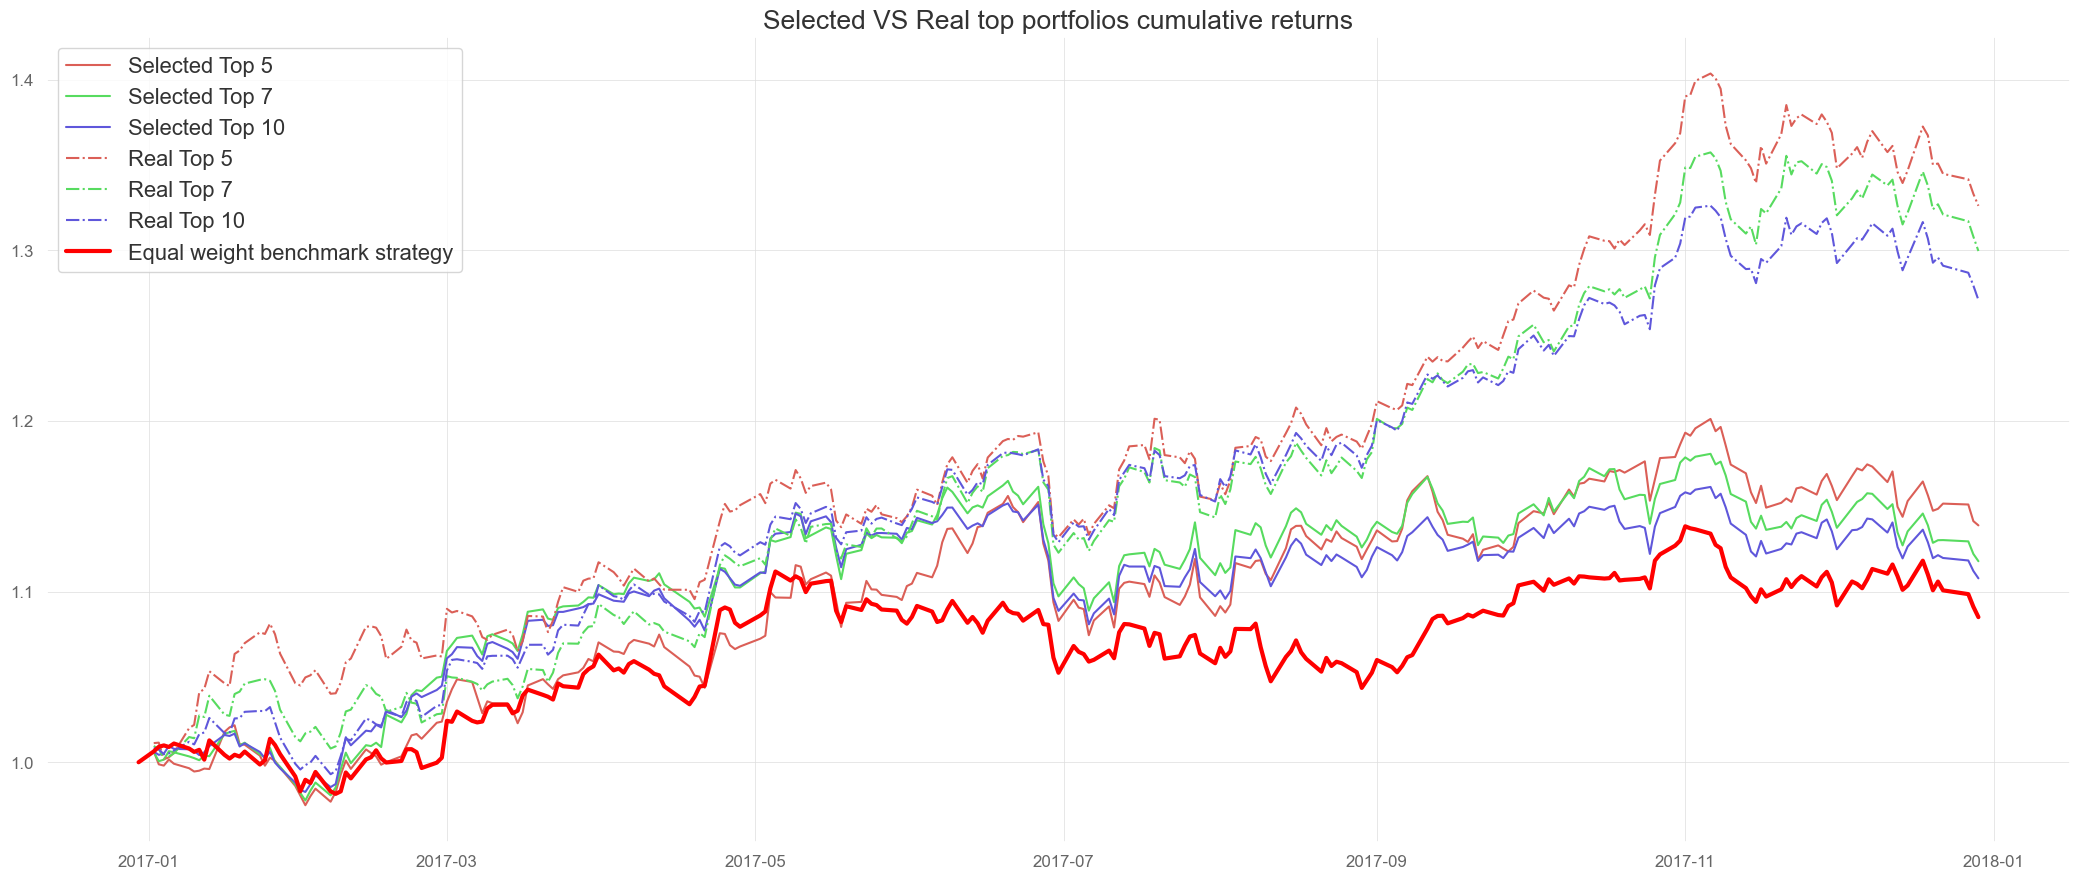

In [26]:
palette = sns.color_palette("hls", 3)
fig, ax = plt.subplots(figsize=(21, 9), tight_layout=True)

for k, color in zip(ret_dict_forecast.keys(), palette):
    s = ret_dict_forecast[k]
    l = cumulative_returns_from_series(s, log=False)
    ax.plot(l, label="Selected " + k, color=color)
    #ax.text(l.index[-1], l.iloc[-1], f"  {l.iloc[-1]:.3f}", color=color, horizontalalignment="left")

for k, color in zip(ret_dict.keys(), palette):
    s = ret_dict[k]
    l = cumulative_returns_from_series(s, log=False)
    ax.plot(l, label="Real " + k, color=color, linestyle="-.")
    #ax.text(l.index[-1], l.iloc[-1], f"  {l.iloc[-1]:.3f}", color=color, horizontalalignment="left")

ax.plot(ew_benchmark, label=ew_benchmark.name, color="red", linewidth=3)

ax.legend(fontsize="large")
ax.set_title("Selected VS Real top portfolios cumulative returns", fontsize="x-large")
plt.plot();

In [27]:
pd.concat([df_perf_real, df_perf_selected], axis=1)

,Real,Selected
Top 5,32.609732,13.882124
Top 7,29.959659,11.782616
Top 10,27.091522,10.779587
